# GNN-EGG
- Author: Art Taychameekiatchai

## Introduction and Related Work

[5 Points] Motivate the need for the research project. Why is this investigation important? What related work are you building from? What are the main research question(s)? What is your hypothesis for what will happen? Try to make this the first draft of the introduction and related work for the final paper. 

- Graph Neural Networks (GNN) are a class of very powerful predictive algorithms, but like many deep learning methods, it can be hard to extract scientific insight.

- Graph classification in particular has many medical applications, such drug development and diagnosis.

- Explainable AI is important for two main reasons. First it can help drive modeling efforts by highlight what types of features the model is using. Second it helps prevent intentional or unintentional discrimination.

- We a mainly building on the work of GNNInterpreter, which attempts to explain the decision making process of a GNN be training a generator model to produce representative examples of classes. We make use of a very similar generation scheme using independent continuously relaxes discrete distribution to generate the matrices that make up a graph. We extend GNNInterpreter my modify the loss function to include comparisons at multiple embedding levels as well as Graph Edit Distance to encourage structural similarity at the graph level. 

- GNNInterpreter trains by minimize the distance in the latent space; however, we are concerned that this might not result in a lessened distance in the graph space. One question of interest is whether the inclusion of GED in the loss function will ensure structural similarity in the graph space, while still allowing training in the latent space? We expected that with the right hyperparameters, we can achieve similar results to existing methods, while 
maintaining or improving the graph level similarity. 

- Another concern is how explanation methods from GNNs are evaluated. Typically it is done by looking at the predicted probability interval for the desired class. This can be problematic as the authors of GNNInterpreter 
found that GNN models across 4 datasets had strong class preference even when the graphs were entirely random.   
Does the inclusion of GED or multiple embedding levels have the same bias? We expected that both metrics will be less biased on random graphs or out of sample graphs.  

- We also hope to provide a better visual comparison between generated and observed graphs. Typically this has been done qualitatively, but we hope to add visual quantitative metrics by using graph matching to identify the most similar sub-graphs. We also hope to be able to draw these comparisons from one generated graph to multiple observed graph, so that common structures might be identified. 

## Methods

[5 Points] You have a great deal of free rein to decide what analyses you should use and therefore you will be graded on the appropriateness of the methods chosen.  Argue for a few analyses that can help to answer your research question. You should argue for more than one kind of analysis to help answer your research questions. Try to make this the first draft of the methods section for a final paper.

- We will train a generator model similar to GNNInterpreter adding the two terms mentioned above to the loss function. 

- We will evaluate our model using the methods common in the literature. Class prediction intervals and visual inspection. In addition be assess the GED intervals and further the visual inspection via graph matching.  

- To evaluate the theoretical strength of our loss terms, we will assess the bias of GED in comparison to latent space distances using a simulation study. 

- Mathematical details in the draft paper.

## Results

[5 Points] Perform one part of the analysis to help answer one (or more) research question(s). Create visualizations that will help to provide evidence. Discuss the results and how they provide evidence for answering the research questions. Try to make this a first draft of one section of the results in your final paper. Try to have at least one visualization that you plan to use as a figure in the final paper. 

In [15]:
import os
import sys
sys.path.append("..")

import dill as pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric.nn as GCNConv

from egg_models import egg_generic_losses
from egg_models.egg_generic import EggGeneric
from egg_models.egg_generic import EggGeneric
from functools import partial
from matplotlib.patches import ConnectionPatch
from scipy.stats import gaussian_kde, t
from utils import mutag_helper
from utils import visuals
import pygmtools as pygm
import networkx as nx

from egg_models.egg_generic_losses import activation_hook, dict_cos_dist, GEDasMatchLoss
from scipy.stats import stats


### Simulation Study

In [16]:
def sample_graph_dist(n, min_nodes, max_nodes, 
                      cont_node_loc, cont_edge_loc, 
                      cont_node_sd, cont_edge_sd,
                      prob_X_d, prob_E_d, prob_A, 
                      cluster_lab):
    samples = []

    # Define feature distributions. 

    X_c_dist = td.Normal(cont_node_loc, cont_node_sd)
    E_c_dist = td.Normal(cont_edge_loc, cont_edge_sd) 
    X_d_dist = td.Bernoulli(prob_X_d)
    E_d_dist = td.Bernoulli(prob_E_d)
    A_dist = td.Bernoulli(prob_A)

    for i in range(n):
        # Sample the number of nodes from a discrete uniform.
        num_nodes = torch.randint(min_nodes, max_nodes, (1, )).item()

        # Sample the adjacency matrix.
        A = A_dist.sample(torch.Size([num_nodes, num_nodes]))
        A, _ = pyg.utils.dense_to_sparse(A)
        num_edges = A.shape[1]

        # Sample continuous features.
        X_c = X_c_dist.sample(torch.Size([num_nodes]))
        E_c = E_c_dist.sample(torch.Size([num_edges]))

        # Sample discrete_feature.
        X_d = X_d_dist.sample(torch.Size([num_nodes]))
        E_d = E_d_dist.sample(torch.Size([num_edges]))

        samples.append(
            pyg.data.Data(x = torch.stack((X_c, X_d), 1), 
                          edge_attr=torch.stack((E_c, E_d), 1), 
                          edge_index = A, y = cluster_lab)
        )

    return samples

class EdgeNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EdgeNN, self).__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.fc2 = nn.Linear(out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, E):
        E = F.relu(self.fc1(E))
        E = self.dropout(E)
        E = F.relu(self.fc2(E))
        E = torch.mean(E, dim=0)

        return E

class NNConv(nn.Module):
    def __init__(self):
        super(NNConv, self).__init__()

        self.nnConv1 = pyg.nn.NNConv(in_channels=2, out_channels=10, 
            nn=EdgeNN(in_channels=2, out_channels=20), 
            aggr='mean', root_weight = True        
        )

        self.nnConv2 = pyg.nn.NNConv(in_channels=10, out_channels=5, 
            nn=EdgeNN(in_channels=2, out_channels=50), 
            aggr='mean', root_weight = True        
        )

        self.nnConv3 = pyg.nn.NNConv(in_channels=5, out_channels=2, 
            nn=EdgeNN(in_channels=2, out_channels=10), 
            aggr='mean', root_weight = True        
        )

    def forward(self, data):
        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index

        x = self.nnConv1(x=x, edge_index=edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.nnConv2(x=x, edge_index=edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.nnConv3(x=x, edge_index=edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = pyg.nn.global_mean_pool(x, data.batch)
        return x

def train_embeddings(model, data_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(10):
        for i, batch in enumerate(data_loader):
            optimizer.zero_grad() 

            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()

            optimizer.step()


def extract_avg_embeddings(model, data_loader):
    activation_names = ["nnConv1", "nnConv2"]
    train_avg_embedding_0 = {"nnConv1": [], "nnConv2": []}
    train_avg_embedding_1 = {"nnConv1": [], "nnConv2": []}
    pool_func = pyg.nn.global_mean_pool

    num_class_1 = 0
    num_class_0 = 0

    correct_1 = 0
    correct_0 = 0
    
    model.eval()

    for i, batch in enumerate(data_loader): 
        acts, remove_hooks = activation_hook(model, activation_names)
        pred_class = torch.argmax(model(batch), dim=1)
        remove_hooks()

        if batch.y.item() == 1:
            num_class_1 += 1

            for name in activation_names: 
                embed = pool_func(acts[name], batch.batch)
                train_avg_embedding_1[name].append(
                    embed.detach().to('cpu')
                )

            if pred_class.item() == 1: 
                correct_1 += 1

        elif batch.y.item() == 0: 
            num_class_0 += 1

            for name in activation_names:
                embed = pool_func(acts[name], batch.batch)
                train_avg_embedding_0[name].append(
                    embed.detach().to('cpu')
                )

            if pred_class.item() == 0: 
                correct_0 += 1

        assert batch.y.item() == 1 or batch.y.item() == 0

    acc_1 = correct_1 / num_class_1
    acc_0 = correct_0 / num_class_0

    print(f"Class 1 Accuracy: {acc_1} Class 0 Accuracy {acc_0}")

    for name in activation_names:
        train_avg_embedding_1[name] = torch.stack(
            train_avg_embedding_1[name]
        ).mean(dim=0)

        train_avg_embedding_0[name] = torch.stack(
            train_avg_embedding_0[name]
        ).mean(dim=0)

    return [train_avg_embedding_0, train_avg_embedding_1]

def get_embed_dist(model, data, avg_embeds):

    activation_names = ["nnConv1", "nnConv2"]
    distance = 0

    model.eval()
    loader = pyg.loader.DataLoader(data)

    for batch in loader: 
        acts, remove_hooks = activation_hook(model, activation_names)
        out = model(batch)
        remove_hooks()

        distance += (dict_cos_dist(
            acts, avg_embeds, batch.batch
        ) / 2).item()
    
    return distance / len(loader)

def extract_avg_embeddings_only_2(model, data_loader):
    activation_names = ["nnConv2"]
    train_avg_embedding_0 = {"nnConv2": []}
    train_avg_embedding_1 = {"nnConv2": []}
    pool_func = pyg.nn.global_mean_pool

    num_class_1 = 0
    num_class_0 = 0

    correct_1 = 0
    correct_0 = 0
    
    model.eval()

    for i, batch in enumerate(data_loader): 
        acts, remove_hooks = activation_hook(model, activation_names)
        pred_class = torch.argmax(model(batch), dim=1)
        remove_hooks()

        if batch.y.item() == 1:
            num_class_1 += 1

            for name in activation_names: 
                embed = pool_func(acts[name], batch.batch)
                train_avg_embedding_1[name].append(
                    embed.detach().to('cpu')
                )

            if pred_class.item() == 1: 
                correct_1 += 1

        elif batch.y.item() == 0: 
            num_class_0 += 1

            for name in activation_names:
                embed = pool_func(acts[name], batch.batch)
                train_avg_embedding_0[name].append(
                    embed.detach().to('cpu')
                )

            if pred_class.item() == 0: 
                correct_0 += 1

        assert batch.y.item() == 1 or batch.y.item() == 0

    acc_1 = correct_1 / num_class_1
    acc_0 = correct_0 / num_class_0

    print(f"Class 1 Accuracy: {acc_1} Class 0 Accuracy {acc_0}")

    for name in activation_names:
        train_avg_embedding_1[name] = torch.stack(
            train_avg_embedding_1[name]
        ).mean(dim=0)

        train_avg_embedding_0[name] = torch.stack(
            train_avg_embedding_0[name]
        ).mean(dim=0)

    return [train_avg_embedding_0, train_avg_embedding_1]

def get_embed_dist_only_2(model, data, avg_embeds):

    activation_names = ["nnConv2"]
    distance = 0

    model.eval()
    loader = pyg.loader.DataLoader(data)

    for batch in loader: 
        acts, remove_hooks = activation_hook(model, activation_names)
        out = model(batch)
        remove_hooks()

        distance += (dict_cos_dist(
            acts, avg_embeds, batch.batch
        ) / 2).item()
    
    return distance / len(loader)

def get_GED_between(data1, data2, ged_fn):
    avg_ged = 0
    for (graph_0, graph_1) in zip(data1, data2):

        # smaller graph first: 
        smaller = (
            (graph_1.x.shape[0] + graph_1.edge_index.shape[1]) < 
            (graph_0.x.shape[0] + graph_0.edge_index.shape[1])
        )
        if smaller:
            temp = graph_0
            graph_0 = graph_1
            graph_1 = temp 

        ged = ged_fn(
            graph_0.x.unsqueeze(0), graph_0.edge_index.unsqueeze(0), 
                graph_0.edge_attr.unsqueeze(0), 
            graph_1.x.unsqueeze(0), graph_1.edge_index.unsqueeze(0),
                graph_1.edge_attr.unsqueeze(0), 
        )

        avg_ged += (
            ged / (graph_0.x.shape[0] + graph_0.edge_index.shape[1])
        ).item()

    return avg_ged / len(data1)

def get_GED_within(data, GED_fn):

    avg_GED = 0
    for i in range(0, len(data), 2): 
        graph_0 = data[i]
        graph_1 = data[i + 1]

        # Smaller Graph First: 
        smaller = (
            (graph_1.x.shape[0] + graph_1.edge_index.shape[1]) < 
            (graph_0.x.shape[0] + graph_0.edge_index.shape[1])
        )
        if smaller:
            temp = graph_0
            graph_0 = graph_1
            graph_1 = temp 

        GED = GED_fn(
            graph_0.x.unsqueeze(0), graph_0.edge_index.unsqueeze(0), 
                graph_0.edge_attr.unsqueeze(0), 
            graph_1.x.unsqueeze(0), graph_1.edge_index.unsqueeze(0),
                graph_1.edge_attr.unsqueeze(0), 
        )

        avg_GED += (
            GED / (graph_0.x.shape[0] + graph_0.edge_index.shape[1])
        ).item()

    return avg_GED / (len(data) / 2)

def t_confidence_interval(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    n = len(data)
    t_value = t.ppf(0.975, df=n-1) 
    margin_of_error = t_value * (std_dev / np.sqrt(n))
    lower_bound = np.round(mean - margin_of_error, 4)
    upper_bound = np.round(mean + margin_of_error, 4)

    print(f"({lower_bound}, {upper_bound})")

#### Simluation 1

In [ ]:
# Parameters
c0_loc = -1
c1_loc = 1
c2_loc = 0

c0_n_min = 75
c0_n_max = 100

c1_n_min = 50
c1_n_max = 75

c2_n_min = 10
c2_n_max = 35

TRAINING_SAMPLES = 50
TESTING_SAMPLES = 50 # has to be even for paired comparisons.
TRIALS = 25

# Return lists
embed_within_0 = []
embed_between_01 = []
embed_between_02 = []

embed_within_1 = []
embed_between_10 = []
embed_between_12 = []

embed_within_0_only_2 = []
embed_between_01_only_2 = []
embed_between_02_only_2 = []

embed_within_1_only_2 = []
embed_between_10_only_2 = []
embed_between_12_only_2 = []

GED_within_0 = []
GED_within_1 = []

GED_between_01 = [] 

GED_between_02 = [] 
GED_between_12 = []

# Partial Functions
base_distribution = partial(sample_graph_dist, 
    cont_edge_loc=0, 
    cont_node_sd=1, cont_edge_sd=1, 
    prob_X_d=0.25, prob_E_d=0.25, 
    prob_A=1e-2
)

cluster_0_dist = partial(base_distribution, 
    cont_node_loc=c0_loc, cluster_lab=torch.tensor([0]), 
    min_nodes=c0_n_min, max_nodes=c0_n_max, 
    #prob_A = 5e-3
)

cluster_1_dist = partial(base_distribution, 
    cont_node_loc=c1_loc, cluster_lab=torch.tensor([1]), 
    min_nodes=c1_n_min, max_nodes=c1_n_max, 
    #prob_A = 1e-2
)

cluster_2_dist = partial(base_distribution, 
    cont_node_loc=c2_loc, cluster_lab=torch.tensor([2]), 
    min_nodes=c2_n_min, max_nodes=c2_n_max, 
    #prob_A = 1e-2
)

GED_fn = GEDasMatchLoss(
    1, (0, ), (1, ), (0, ), (1, )
)


for trial in range(TRIALS):
    c0_train = cluster_0_dist(n = TRAINING_SAMPLES)
    c1_train = cluster_1_dist(n = TRAINING_SAMPLES)

    train_data_loader = pyg.loader.DataLoader(
        c0_train + c1_train, shuffle=True
    )

    model = NNConv()

    train_embeddings(model, train_data_loader)

    avg_c0_embeds, avg_c1_embeds = extract_avg_embeddings(model, 
                                                          train_data_loader) 

    avg_c0_embeds_only_2, avg_c1_embeds_only_2 = extract_avg_embeddings_only_2(
        model, train_data_loader
    )

    c0_test = cluster_0_dist(n = TESTING_SAMPLES)
    c1_test = cluster_1_dist(n = TESTING_SAMPLES)
    c2 = cluster_2_dist(n = TESTING_SAMPLES)

    embed_within_0.append(get_embed_dist(model, c0_test, avg_c0_embeds))
    embed_within_1.append(get_embed_dist(model, c1_test, avg_c1_embeds))

    embed_between_01.append(get_embed_dist(model, c0_test, avg_c1_embeds))
    embed_between_10.append(get_embed_dist(model, c1_test, avg_c0_embeds))

    embed_between_02.append(get_embed_dist(model, c2, avg_c0_embeds))
    embed_between_12.append(get_embed_dist(model, c2, avg_c1_embeds))

    embed_within_0_only_2.append(get_embed_dist_only_2(model, c0_test, avg_c0_embeds_only_2))
    embed_within_1_only_2.append(get_embed_dist_only_2(model, c1_test, avg_c1_embeds_only_2))

    embed_between_01_only_2.append(get_embed_dist_only_2(model, c0_test, avg_c1_embeds_only_2))
    embed_between_10_only_2.append(get_embed_dist_only_2(model, c1_test, avg_c0_embeds_only_2))

    embed_between_02_only_2.append(get_embed_dist_only_2(model, c2, avg_c0_embeds_only_2))
    embed_between_12_only_2.append(get_embed_dist_only_2(model, c2, avg_c1_embeds_only_2))

    GED_within_0.append(get_GED_within(c0_test, GED_fn))
    GED_within_1.append(get_GED_within(c1_test, GED_fn))

    GED_between_01.append(get_GED_between(c0_test, c1_test, GED_fn))

    GED_between_02.append(get_GED_between(c0_test, c2, GED_fn))
    GED_between_12.append(get_GED_between(c1_test, c2, GED_fn))

lists_dict = {
    "embed_within_0": embed_within_0,
    "embed_between_01": embed_between_01,
    "embed_between_02": embed_between_02,
    "embed_within_1": embed_within_1,
    "embed_between_10": embed_between_10,
    "embed_between_12": embed_between_12,
    "embed_within_0_only_2": embed_within_0_only_2,
    "embed_between_01_only_2": embed_between_01_only_2,
    "embed_between_02_only_2": embed_between_02_only_2,
    "embed_within_1_only_2": embed_within_1_only_2,
    "embed_between_10_only_2": embed_between_10_only_2,
    "embed_between_12_only_2": embed_between_12_only_2,
    "GED_within_0": GED_within_0,
    "GED_within_1": GED_within_1,
    "GED_between_01": GED_between_01,
    "GED_between_02": GED_between_02,
    "GED_between_12": GED_between_12
}

for list_name in lists_dict:
    print(f"{list_name}: ")
    t_confidence_interval(lists_dict[list_name])
    print("\n")

- In this simulation the out of sample distribution is between the two seen during training. We would expect a robust distance metric to find that the out of sample graphs are close to equally distant from the one seen during training.

- Using only the final embedding resulted in a clear preference for class 1, with the interval not overlapping.   

    - embed_between_12_only_2: (0.118, 0.1956)

    - embed_between_02_only_2: (0.2868, 0.4398)

- Using multiple embedding didn't actually reduce the bias. The distance to cluster 1 is about half the distance to cluster 2 

    - embed_between_12: (0.1986, 0.2904)

    - embed_between_02: (0.3933, 0.5231)

- Some of the bias can be attributed to graph size; however, size mismatch between classes is common, and if the goal is to generate subgraph explanations using embeddings would bias the model towards the smaller graphs regardless of features or structure.  

- GED does appear more robust. The lean towards class 1 should be more manageable during training.  

    - GED_between_12: (0.758, 0.7705)

    - GED_between_02: (0.7819, 0.7907)

#### Simulation 2

In [ ]:
# Parameters
c0_loc = -1
c1_loc = 1
c2_loc = -3

c0_n_min = 75
c0_n_max = 100

c1_n_min = 50
c1_n_max = 75

c2_n_min = 10
c2_n_max = 35

TRAINING_SAMPLES = 20
TESTING_SAMPLES = 20 # has to be even for paired comparisons.
TRIALS = 50

# Return lists
embed_within_0 = []
embed_between_01 = []
embed_between_02 = []

embed_within_1 = []
embed_between_10 = []
embed_between_12 = []

embed_within_0_only_2 = []
embed_between_01_only_2 = []
embed_between_02_only_2 = []

embed_within_1_only_2 = []
embed_between_10_only_2 = []
embed_between_12_only_2 = []

GED_within_0 = []
GED_within_1 = []

GED_between_01 = [] 

GED_between_02 = [] 
GED_between_12 = []

# Partial Functions
base_distribution = partial(sample_graph_dist, 
    cont_edge_loc=0, 
    cont_node_sd=1, cont_edge_sd=1, 
    prob_X_d=0.25, prob_E_d=0.25, 
    prob_A=1e-2
)

cluster_0_dist = partial(base_distribution, 
    cont_node_loc=c0_loc, cluster_lab=torch.tensor([0]), 
    min_nodes=c0_n_min, max_nodes=c0_n_max, 
    # prob_A = 5e-3
)

cluster_1_dist = partial(base_distribution, 
    cont_node_loc=c1_loc, cluster_lab=torch.tensor([1]), 
    min_nodes=c1_n_min, max_nodes=c1_n_max, 
    # prob_A = 1e-2
)

cluster_2_dist = partial(base_distribution, 
    cont_node_loc=c2_loc, cluster_lab=torch.tensor([2]), 
    min_nodes=c2_n_min, max_nodes=c2_n_max, 
    # prob_A = 1e-2
)

GED_fn = GEDasMatchLoss(
    1, (0, ), (1, ), (0, ), (1, )
)


for trial in range(TRIALS):
    c0_train = cluster_0_dist(n = TRAINING_SAMPLES)
    c1_train = cluster_1_dist(n = TRAINING_SAMPLES)

    train_data_loader = pyg.loader.DataLoader(
        c0_train + c1_train, shuffle=True
    )

    model = NNConv()

    train_embeddings(model, train_data_loader)

    avg_c0_embeds, avg_c1_embeds = extract_avg_embeddings(model, 
                                                          train_data_loader) 

    avg_c0_embeds_only_2, avg_c1_embeds_only_2 = extract_avg_embeddings_only_2(
        model, train_data_loader
    )

    c0_test = cluster_0_dist(n = TESTING_SAMPLES)
    c1_test = cluster_1_dist(n = TESTING_SAMPLES)
    c2 = cluster_2_dist(n = TESTING_SAMPLES)

    embed_within_0.append(get_embed_dist(model, c0_test, avg_c0_embeds))
    embed_within_1.append(get_embed_dist(model, c1_test, avg_c1_embeds))

    embed_between_01.append(get_embed_dist(model, c0_test, avg_c1_embeds))
    embed_between_10.append(get_embed_dist(model, c1_test, avg_c0_embeds))

    embed_between_02.append(get_embed_dist(model, c2, avg_c0_embeds))
    embed_between_12.append(get_embed_dist(model, c2, avg_c1_embeds))

    embed_within_0_only_2.append(get_embed_dist_only_2(model, c0_test, avg_c0_embeds_only_2))
    embed_within_1_only_2.append(get_embed_dist_only_2(model, c1_test, avg_c1_embeds_only_2))

    embed_between_01_only_2.append(get_embed_dist_only_2(model, c0_test, avg_c1_embeds_only_2))
    embed_between_10_only_2.append(get_embed_dist_only_2(model, c1_test, avg_c0_embeds_only_2))

    embed_between_02_only_2.append(get_embed_dist_only_2(model, c2, avg_c0_embeds_only_2))
    embed_between_12_only_2.append(get_embed_dist_only_2(model, c2, avg_c1_embeds_only_2))

    GED_within_0.append(get_GED_within(c0_test, GED_fn))
    GED_within_1.append(get_GED_within(c1_test, GED_fn))

    GED_between_01.append(get_GED_between(c0_test, c1_test, GED_fn))

    GED_between_02.append(get_GED_between(c0_test, c2, GED_fn))
    GED_between_12.append(get_GED_between(c1_test, c2, GED_fn))

lists_dict = {
    "embed_within_0": embed_within_0,
    "embed_between_01": embed_between_01,
    "embed_between_02": embed_between_02,
    "embed_within_1": embed_within_1,
    "embed_between_10": embed_between_10,
    "embed_between_12": embed_between_12,
    "embed_within_0_only_2": embed_within_0_only_2,
    "embed_between_01_only_2": embed_between_01_only_2,
    "embed_between_02_only_2": embed_between_02_only_2,
    "embed_within_1_only_2": embed_within_1_only_2,
    "embed_between_10_only_2": embed_between_10_only_2,
    "embed_between_12_only_2": embed_between_12_only_2,
    "GED_within_0": GED_within_0,
    "GED_within_1": GED_within_1,
    "GED_between_01": GED_between_01,
    "GED_between_02": GED_between_02,
    "GED_between_12": GED_between_12
}

for list_name in lists_dict:
    print(f"{list_name}: ")
    t_confidence_interval(lists_dict[list_name])
    print("\n")

- The bias using embeddings is exacerbated when the out of sample mean is far to one side of the embedding space.  
A mean node feature of -3 should ideally be not that close to a class of graph that has a mean of -1 under a normal distribution. Yet, 

    - embed_between_02: (0.0158, 0.0199) v. embed_within_0: (0.0013, 0.0023)

    - embed_between_02_only_2: (0.0208, 0.0268) v. embed_within_0_only_2: (0.0014, 0.0033)

- The problem is that is the generator's parameters are initialized far to one side of the embedding space, 
it might not move because it thinks the loss is already small, when it probably shouldn't be. 

- GED appears more robust:

    - GED_within_0: (0.4157, 0.4201) v. GED_between_02: (0.6217, 0.6323)

    - GED_within_1: (0.463, 0.4697) v. GED_between_12: (0.8248, 0.833)

    - The distance measure is closer to 0, but not so close that it would be mistaken for the same class. 

### Training Generator Models

In [ ]:
# fix random seeds for reproducibility.
SEED = 123123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True 
np.random.seed(SEED)

In [ ]:
# Meta-Data
device = torch.device(0)

In [ ]:
# Load explainee model.
explainee = mutag_helper.GCN(hidden_channels=64)

explainee.to(device)
explainee.load_state_dict(torch.load(
        "../data/explainees/MUTAG/gcn_200.pt", 
        map_location=device
    ), 
    strict=False
)
explainee.eval()

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
# Load cleaned datasets.
# See MUTAG.ipynb for code used to generate the data. 

base_path = "../data/explainees/MUTAG/"

with open(base_path + "MUTAG_train_data_list.pkl", "rb") as f:
    train_data_list = pickle.load(f)

with open(os.path.join(base_path, "MUTAG_train_data_list_1.pkl"), "rb") as f:
    train_data_list_1 = pickle.load(f)

with open(base_path + "MUTAG_train_data_list_0.pkl", "rb") as f:
    train_data_list_0 = pickle.load(f)

with open(base_path + "MUTAG_test_data_list.pkl", "rb") as f:
    test_data_list = pickle.load(f)

with open(base_path + "MUTAG_test_data_list_1.pkl", "rb") as f:
    test_data_list_1 = pickle.load(f)

with open(base_path + "MUTAG_test_data_list_0.pkl", "rb") as f:
    test_data_list_0 = pickle.load(f)

with open(base_path + "MUTAG_train_avg_embedding_dict_0.pkl", 'rb') as f: 
    avg_class_embedding_0 = pickle.load(f)

with open(base_path + "MUTAG_train_avg_embedding_dict_1.pkl", 'rb') as f: 
    avg_class_embedding_1 = pickle.load(f)

In [ ]:
# Common Functions
max_node_size = 5

def t_confidence_interval(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    n = len(data)
    t_value = stats.t.ppf(0.975, df=n-1) 
    margin_of_error = t_value * (std_dev / np.sqrt(n))
    lower_bound = np.round(mean - margin_of_error, 4)
    upper_bound = np.round(mean + margin_of_error, 4)

    print(f"({lower_bound}, {upper_bound})")

# L2
GED_fn = egg_generic_losses.GEDasMatchLoss(
    node_size=max_node_size, 
    cont_node_indices=None, 
    dis_node_indices=(slice(0, 6), ), 
    cont_edge_indices=None, 
    dis_edge_indices=(slice(0, 4), )
)

In [ ]:
# Compute Baseline Metrics

generator_untrained = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    batch_size=16
)
generator_untrained.to(device)

runner = 0.0
for i in range(100):
    with torch.no_grad():
        gen_ex = mutag_helper.egg_to_ex(generator_untrained())
        pred = torch.softmax(explainee(gen_ex), dim=-1).mean(dim=0)
        runner += pred.cpu().numpy()

print(f"Untrained Predicted Probability Means: {runner / 100}")

loader = pyg.loader.DataLoader(train_data_list_1, batch_size=16, drop_last=True)
running_GED = 0
for batch in loader:
    batch.to(device)
    generated = generator_untrained()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)


    loss = GED_fn(*gen_egg, *obs_egg) / (batch.x.shape[0] + batch.edge_attr.shape[0])
    running_GED += loss.mean().item()

print(f"Untrained % Edit Distance to 1: {100 * running_GED / len(loader)}")

loader = pyg.loader.DataLoader(train_data_list_0, batch_size=16, drop_last=True)
running_GED = 0
for batch in loader:
    batch.to(device)
    generated = generator_untrained()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (batch.x.shape[0] + batch.edge_attr.shape[0])
    running_GED += loss.mean().item()

print(f"Untrained % Edit Distance to 0: {100 * running_GED / len(loader)}")

Untrained Predicted Probability Means: [0.8073292  0.19267109]
Untrained % Edit Distance to 1: 1.129374575490753
Untrained % Edit Distance to 0: 1.7207512632012367


In [ ]:
# Train generator targeting class 1. 

target = torch.tensor([0.0, 1.0]) # t
uninfo = torch.tensor([0.5, 0.5]) # u
gamma = F.cross_entropy(target, uninfo)
max_node_size = 5

generator_1 = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    batch_size=16
)
generator_1.to(device)

# L1
pred_loss_fn = egg_generic_losses.PredLossBatched(
    target, explainee
)


loader = pyg.loader.DataLoader(train_data_list, batch_size=16, drop_last=True)

optimizer = torch.optim.RMSprop(generator_1.parameters())  
scheduler1 = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[25, 50, 75]
)

num_epochs = 100
for i in range(num_epochs):
    running_loss = 0.0
    for obs_batch in loader:
        obs_batch.to(device)

        gen_graph = generator_1()

        # Convert to format accepted by explainee.
        gen_ex = mutag_helper.egg_to_ex(gen_graph) 

        # Convert to format accepted by L2 and L3. 
        gen_egg = mutag_helper.egg_to_egg(gen_graph)

        # Convert to format accepted by L2 and L3. 
        obs_egg = mutag_helper.ex_to_egg(obs_batch)

        # Compute L1.
        loss_1, _, _ = pred_loss_fn(gen_ex) 
        loss_1 = 1e-2 * loss_1.mean() # Lambda_1

        # Compute omega.
        with torch.no_grad():
            explainee_pred = F.softmax(explainee(obs_batch), dim=-1)
            omega = (gamma - 
                    F.cross_entropy(
                        explainee_pred, 
                        target.expand_as(explainee_pred).to(explainee_pred.device),
                        reduction='none'
                    )
            ) ** 3
        
        # Compute L2. 
        loss_2 = GED_fn(*gen_egg, *obs_egg)

        # Compute L3. 
        loss_3 = 1.0 * omega * loss_2 # Lambda_2
        loss_3_reinforced = loss_3.mean() + (
            ((1 / loss_3) @ -gen_graph['A_logLik']).sum()
        ) * 1e-11 # why does weighting the reinforcement term help?  

        loss = loss_1 + loss_3_reinforced

        running_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(generator_1.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()

    scheduler1.step() 
    print(f"Epoch {i}: Loss: {running_loss / len(loader)}")


Epoch 0: Loss: 0.43408005436261493
Epoch 1: Loss: 0.4243510829077827
Epoch 2: Loss: 0.4217942754427592
Epoch 3: Loss: 0.41319874591297573
Epoch 4: Loss: 0.40397075149748063
Epoch 5: Loss: 0.3991401162412431
Epoch 6: Loss: 0.3923376864857144
Epoch 7: Loss: 0.3829444779290093
Epoch 8: Loss: 0.38344141178660923
Epoch 9: Loss: 0.37711290187305874
Epoch 10: Loss: 0.370612512032191
Epoch 11: Loss: 0.36592158012919956
Epoch 12: Loss: 0.3650534417894151
Epoch 13: Loss: 0.36248762408892315
Epoch 14: Loss: 0.35939840972423553
Epoch 15: Loss: 0.35826556715700364
Epoch 16: Loss: 0.35186266402403515
Epoch 17: Loss: 0.3472270650996102
Epoch 18: Loss: 0.3461655063761605
Epoch 19: Loss: 0.34349334571096635
Epoch 20: Loss: 0.3374081336789661
Epoch 21: Loss: 0.3464465488990148
Epoch 22: Loss: 0.3502518865797255
Epoch 23: Loss: 0.33555565940009224
Epoch 24: Loss: 0.34653673734929824
Epoch 25: Loss: 0.34600556393464404
Epoch 26: Loss: 0.3502819273206923
Epoch 27: Loss: 0.3377627697255876
Epoch 28: Loss: 0

In [ ]:
# Check mean prediction.
runner = 0.0
for i in range(100):
    with torch.no_grad():
        gen_ex = mutag_helper.egg_to_ex(generator_1())
        pred = torch.softmax(explainee(gen_ex), dim=-1).mean(dim=0)
        runner += pred[1].item()

print(runner / 100)

0.9105727362632752


In [ ]:
# Check mean % edit distance.
loader = pyg.loader.DataLoader(train_data_list_1, batch_size=16, drop_last=True)
running_GED = 0
for batch in loader:
    batch.to(device)
    generated = generator_1()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)


    loss = GED_fn(*gen_egg, *obs_egg) / (batch.x.shape[0] + batch.edge_attr.shape[0])
    running_GED += loss.mean().item()

print(f"% Edit Distance to 1: {100 * running_GED / len(loader)}")

loader = pyg.loader.DataLoader(train_data_list_0, batch_size=16, drop_last=True)
running_GED = 0
for batch in loader:
    batch.to(device)
    generated = generator_1()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (batch.x.shape[0] + batch.edge_attr.shape[0])
    running_GED += loss.mean().item()
3
print(f" % Edit Distance to 0: {100 * running_GED / len(loader)}")

% Edit Distance to 1: 0.9201751090586185
 % Edit Distance to 0: 1.5420603255430858


In [ ]:
# Train generator targeting class 0. 

target = torch.tensor([1.0, 0.0]) # t
uninfo = torch.tensor([0.5, 0.5]) # u
gamma = F.cross_entropy(target, uninfo)
max_node_size = 5

generator_0 = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    batch_size=16
)
generator_0.to(device)

# L1
pred_loss_fn = egg_generic_losses.PredLossBatched(
    target, explainee
)

loader = pyg.loader.DataLoader(train_data_list, batch_size=16, drop_last=True)

optimizer = torch.optim.RMSprop(generator_0.parameters())  
scheduler1 = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[25, 50, 75]
)

num_epochs = 100
for i in range(num_epochs):
    running_loss = 0.0
    for obs_batch in loader:
        obs_batch.to(device)

        gen_graph = generator_0()

        # Convert to format accepted by explainee.
        gen_ex = mutag_helper.egg_to_ex(gen_graph) 

        # Convert to format accepted by L2 and L3. 
        gen_egg = mutag_helper.egg_to_egg(gen_graph)

        # Convert to format accepted by L2 and L3. 
        obs_egg = mutag_helper.ex_to_egg(obs_batch)

        # Compute L1.
        loss_1, _, _ = pred_loss_fn(gen_ex) 
        loss_1 = 1e-1 * loss_1.mean() # lambda_1

        # Compute omega.
        with torch.no_grad():
            explainee_pred = F.softmax(explainee(obs_batch), dim=-1)
            omega = (gamma - 
                    F.cross_entropy(
                        explainee_pred, 
                        target.expand_as(explainee_pred).to(explainee_pred.device),
                        reduction='none'
                    )
            ) ** 3
        
        # Compute L2. 
        loss_2 = GED_fn(*gen_egg, *obs_egg)

        # Compute L3. 
        loss_3 = 1.0 * omega * loss_2 # lambda_2
        loss_3_reinforced = loss_3.mean() + (
            ((1 / loss_3) @ -gen_graph['A_logLik']).sum()
        ) * 1e-11 # Lambda 

        loss = loss_1 + loss_3_reinforced # Lambdas

        running_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(generator_1.parameters(), 1.0)

        optimizer.step()
        optimizer.zero_grad()
    
    scheduler1.step()
    print(f"Epoch {i}: Loss: {running_loss / len(loader)}")


Epoch 0: Loss: -0.043819353812270694
Epoch 1: Loss: -0.11318731183807056
Epoch 2: Loss: -0.12755999424391323
Epoch 3: Loss: -0.34514741640951896
Epoch 4: Loss: -0.393561478290293
Epoch 5: Loss: -0.581667885184288
Epoch 6: Loss: -0.5541116371750832
Epoch 7: Loss: -0.6084869189394845
Epoch 8: Loss: -0.6980721379319826
Epoch 9: Loss: -0.6936525503794352
Epoch 10: Loss: -0.646910542415248
Epoch 11: Loss: -0.7413950777716107
Epoch 12: Loss: -0.8695119139220979
Epoch 13: Loss: -0.8361887439257569
Epoch 14: Loss: -0.8811087384819984
Epoch 15: Loss: -0.9460564475092623
Epoch 16: Loss: -0.881624549213383
Epoch 17: Loss: -0.9522581597169241
Epoch 18: Loss: -0.9546610460513167
Epoch 19: Loss: -0.9847008587999476
Epoch 20: Loss: -1.0486244385441144
Epoch 21: Loss: -1.1228487094243367
Epoch 22: Loss: -1.1750504813260503
Epoch 23: Loss: -1.1384479192396004
Epoch 24: Loss: -1.1158671416342258
Epoch 25: Loss: -1.1183168097502656
Epoch 26: Loss: -1.0714230040709178
Epoch 27: Loss: -1.2366065118047926
E

In [ ]:
# Check mean prediction
runner = 0.0
for i in range(100):
    with torch.no_grad():
        gen_ex = mutag_helper.egg_to_ex(generator_0())
        pred = torch.softmax(explainee(gen_ex), dim=-1).mean(dim=0)
        runner += pred[0].item()

print(runner / 100)

0.9762812703847885


In [ ]:
# Check mean % edit distance.
loader = pyg.loader.DataLoader(train_data_list_1, batch_size=16, drop_last=True)
running_GED = 0
for batch in loader:
    batch.to(device)
    generated = generator_0()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)


    loss = GED_fn(*gen_egg, *obs_egg) / (batch.x.shape[0] + batch.edge_attr.shape[0])
    running_GED += loss.mean().item()

print(f"% Edit Distance to 1: {100 * running_GED / len(loader)}")

loader = pyg.loader.DataLoader(train_data_list_0, batch_size=16, drop_last=True)
running_GED = 0
for batch in loader:
    batch.to(device)
    generated = generator_0()
    gen_ex = mutag_helper.egg_to_ex(generated)
    gen_egg = mutag_helper.egg_to_egg(generated)
    obs_egg = mutag_helper.ex_to_egg(batch)

    loss = GED_fn(*gen_egg, *obs_egg) / (batch.x.shape[0] + batch.edge_attr.shape[0])
    running_GED += loss.mean().item()

print(f"% Edit Distance to 0: {100 * running_GED / len(loader)}")

% Edit Distance to 1: 1.0479868855327368
% Edit Distance to 0: 1.6315095747510593


- While the prediction intervals are technically worse than existing methods, they are narrow and in the same ballpark, > 90% for both classes. 

- While training reduced the graph edit distance to both classes, the reduction in distance towards class 1 was much greater than class 0 for the generator targeting class 1 (~20% v. ~12%). While the generator targeting class 0 was pulled closer to the class 1, the reduction in distance is not substantially greater (~5% v. ~4%).

### Potential Figures

Text(0.5, 1.0, 'GED: 0.15')

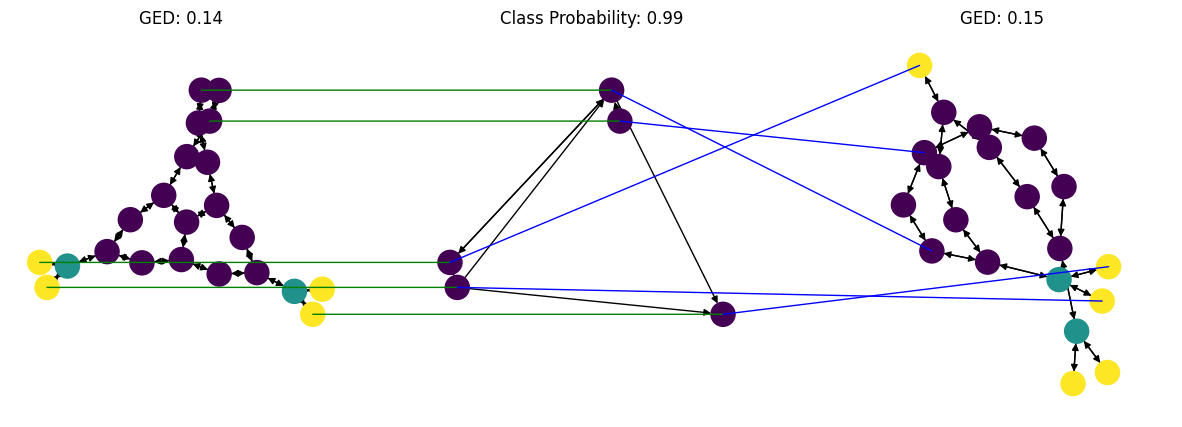

In [ ]:
# Set to single batch for visualizations. 
generator_trained_1 = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    batch_size=1
)
generator_trained_1.load_state_dict(generator_1.state_dict())

gen = generator_trained_1()
gen_ex = mutag_helper.egg_to_ex(gen)
gen_egg = mutag_helper.egg_to_egg(gen)
colors = torch.argmax(gen_ex.x, dim=-1)
gen_nx = pyg.utils.to_networkx(gen_ex)
#nx.draw(gen_nx, node_color = colors)

obs_ex = test_data_list_1[5]
obs_egg = mutag_helper.ex_to_egg(pyg.data.Batch().from_data_list([obs_ex]))
colors = torch.argmax(obs_ex.x, dim=-1)
obs_nx = pyg.utils.to_networkx(obs_ex)
#nx.draw(obs_nx, node_color = colors)

obs_ex2 = test_data_list_1[0]
obs_egg2 = mutag_helper.ex_to_egg(pyg.data.Batch().from_data_list([obs_ex2]))
colors2 = torch.argmax(obs_ex2.x, dim=-1)
obs_nx2 = pyg.utils.to_networkx(obs_ex2)

with torch.no_grad():
    aff_mat = GED_fn.get_aff_mat(*gen_egg, *obs_egg)
    dis_match_mat = GED_fn.get_dis_match_mat(aff_mat)

with torch.no_grad():
    aff_mat2 = GED_fn.get_aff_mat(*gen_egg, *obs_egg2)
    dis_match_mat2 = GED_fn.get_dis_match_mat(aff_mat2)

GED_score = (
    -1 * pygm.utils.compute_affinity_score(dis_match_mat, aff_mat) / 
    (obs_ex.x.shape[0] + obs_ex.edge_attr.shape[0])
).item()
pred_score = torch.softmax(explainee(gen_ex.to(device)), dim=-1)[:, 1].item()
gen_ex.cpu()

GED_score2 = (
    -1 * pygm.utils.compute_affinity_score(dis_match_mat2, aff_mat2) / 
    (obs_ex2.x.shape[0] + obs_ex2.edge_attr.shape[0])
).item()

pos_1 = nx.spring_layout(obs_nx)
# pos_2 = nx.spring_layout(gen_nx)
pos_2 = {}
for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat.squeeze()[i]).item()
    pos_2[i] = pos_1[j]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

nx.draw(obs_nx, node_color = colors, pos = pos_1, ax=axes[0])

nx.draw(gen_nx, node_color = torch.argmax(gen_ex.x, dim=-1), pos=pos_2, ax=axes[1])

for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat.squeeze()[i]).item()
    con = ConnectionPatch(xyA=pos_2[i], xyB=pos_1[j], 
                        coordsA="data", coordsB="data",
                        axesA=axes[0], axesB=axes[1], color="green")

    fig.add_artist(con)

pos_3 = nx.spring_layout(obs_nx2)
# for i in range(gen_ex.x.shape[0]):
#     j = torch.argmax(dis_match_mat.squeeze()[i]).item()
#     pos_3[j] = pos_2[i]

nx.draw(obs_nx2, node_color = colors2, pos = pos_3, ax=axes[2])

for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat2.squeeze()[i]).item()
    con = ConnectionPatch(xyA=pos_3[j], xyB=pos_2[i], 
                        coordsA="data", coordsB="data",
                        axesA=axes[2], axesB=axes[1], color="blue")

    fig.add_artist(con)

axes[0].set_title(f"GED: {GED_score:0.2f}")
axes[1].set_title(f"Class Probability: {pred_score:0.2f}")
axes[2].set_title(f"GED: {GED_score2:0.2f}")

Text(0.5, 1.0, 'GED: 0.23')

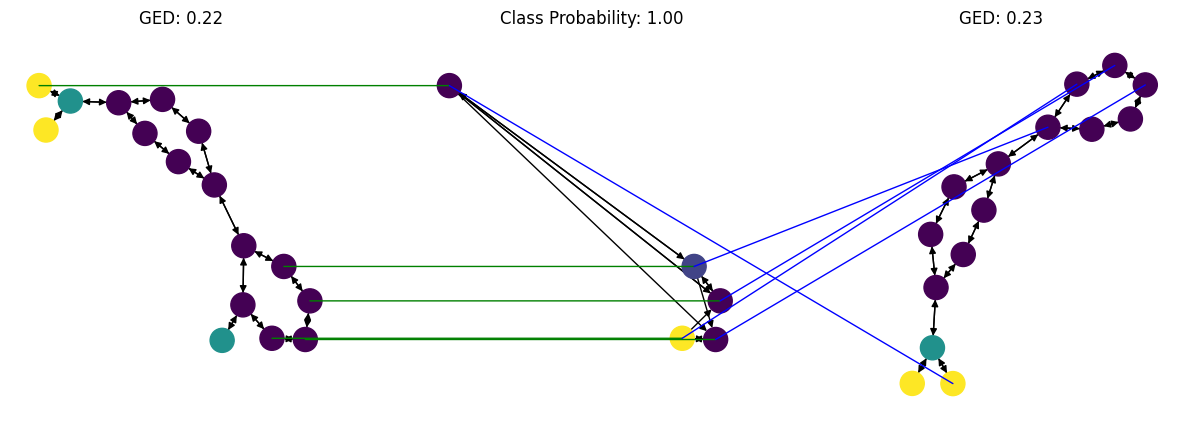

In [ ]:
# Set to single batch for visualizations. 
generator_trained_0 = EggGeneric(
    max_node_size=max_node_size, 
    cont_node_feats=None, 
    dis_node_feats=(7, ), # num cats.
    cont_edge_feats=None, 
    dis_edge_feats=(4, ), # num cats.
    batch_size=1
)
generator_trained_0.load_state_dict(generator_0.state_dict())

gen = generator_trained_0()
gen_ex = mutag_helper.egg_to_ex(gen)
gen_egg = mutag_helper.egg_to_egg(gen)
colors = torch.argmax(gen_ex.x, dim=-1)
gen_nx = pyg.utils.to_networkx(gen_ex)
#nx.draw(gen_nx, node_color = colors)

obs_ex = test_data_list_0[5]
obs_egg = mutag_helper.ex_to_egg(pyg.data.Batch().from_data_list([obs_ex]))
colors = torch.argmax(obs_ex.x, dim=-1)
obs_nx = pyg.utils.to_networkx(obs_ex)
#nx.draw(obs_nx, node_color = colors)

obs_ex2 = test_data_list_0[1]
obs_egg2 = mutag_helper.ex_to_egg(pyg.data.Batch().from_data_list([obs_ex2]))
colors2 = torch.argmax(obs_ex2.x, dim=-1)
obs_nx2 = pyg.utils.to_networkx(obs_ex2)

with torch.no_grad():
    aff_mat = GED_fn.get_aff_mat(*gen_egg, *obs_egg)
    dis_match_mat = GED_fn.get_dis_match_mat(aff_mat)

with torch.no_grad():
    aff_mat2 = GED_fn.get_aff_mat(*gen_egg, *obs_egg2)
    dis_match_mat2 = GED_fn.get_dis_match_mat(aff_mat2)

GED_score = (
    -1 * pygm.utils.compute_affinity_score(dis_match_mat, aff_mat) / 
    (obs_ex.x.shape[0] + obs_ex.edge_attr.shape[0])
).item()
pred_score = torch.softmax(explainee(gen_ex.to(device)), dim=-1)[:, 0].item()
gen_ex.cpu()

GED_score2 = (
    -1 * pygm.utils.compute_affinity_score(dis_match_mat2, aff_mat2) / 
    (obs_ex2.x.shape[0] + obs_ex2.edge_attr.shape[0])
).item()

pos_1 = nx.spring_layout(obs_nx)
# pos_2 = nx.spring_layout(gen_nx)
pos_2 = {}
for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat.squeeze()[i]).item()
    pos_2[i] = pos_1[j]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

nx.draw(obs_nx, node_color = colors, pos = pos_1, ax=axes[0])

nx.draw(gen_nx, node_color = torch.argmax(gen_ex.x, dim=-1), pos=pos_2, ax=axes[1])

for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat.squeeze()[i]).item()
    con = ConnectionPatch(xyA=pos_2[i], xyB=pos_1[j], 
                        coordsA="data", coordsB="data",
                        axesA=axes[0], axesB=axes[1], color="green")

    fig.add_artist(con)

pos_3 = nx.spring_layout(obs_nx2)
# for i in range(gen_ex.x.shape[0]):
#     j = torch.argmax(dis_match_mat.squeeze()[i]).item()
#     pos_3[j] = pos_2[i]

nx.draw(obs_nx2, node_color = colors2, pos = pos_3, ax=axes[2])

for i in range(gen_ex.x.shape[0]):
    j = torch.argmax(dis_match_mat2.squeeze()[i]).item()
    con = ConnectionPatch(xyA=pos_3[j], xyB=pos_2[i], 
                        coordsA="data", coordsB="data",
                        axesA=axes[2], axesB=axes[1], color="blue")

    fig.add_artist(con)

axes[0].set_title(f"GED: {GED_score:0.2f}")
axes[1].set_title(f"Class Probability: {pred_score:0.2f}")
axes[2].set_title(f"GED: {GED_score2:0.2f}")

- Based on theses few examples, the model looks for groups of yellow node on the outside of the molecule. Typically, having to identify multiple groups to be confident in the predictions. This checks out with the heuristics in the literature that multiple N02 group indicate mutagenic molecules. 

- In contrast the model primarily looks at the rings to determine non-mutagenic molecules. It is possible that the model is also flagging a single NO2 group as evidence. 

- The first example might actually expose a flaw in the explainee model as a graph of pure purple nodes in confidently classified as mutagenic.  